In [1]:
import os
import sys
import json
import math
import base64
from mimetypes import guess_type
from collections import defaultdict
import torch
from PIL import Image
from openai import AzureOpenAI

# Add the tools directory to the path
sys.path.append('/data/users/brandon/ob1-projects/InternVL/internvl_chat/tools')

from reasoning_data_pipeline.utils.accuracy_reward import (check_answer, parse_answer)

from reasoning_data_pipeline.utils.utils import localtime


In [2]:
# Azure OpenAI Configuration
endpoint = "https://dalle-declare.openai.azure.com/"
deployment = "gpt-4.1"
api_version = "2025-01-01-preview"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=os.getenv("AZURE_API_KEY"),
)

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"


In [3]:
class RAVENDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data,
        sample_max_num=None,
        sample_start_idx=0,
    ):
        with open(data) as file:
            self.data = file.readlines()

        if sample_max_num is not None and len(self.data) > sample_max_num:
            print(f'Truncate data lines. {len(self.data)} => {sample_max_num}')
            step = max(len(self.data) // sample_max_num, 1)
            self.data = self.data[sample_start_idx::step][:sample_max_num]
            print(f'Number of data lines after truncation: {len(self.data)=}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = json.loads(self.data[idx])
        
        # RAVEN dataset structure: id, combined_image_path, correct_answer, subset_split
        image_path = item['combined_image_path']
        correct_answer = item['correct_answer']
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        rollout_user_prompt = r"""You are an abstract reasoning puzzle expert. The puzzle you will receive is presented in a standard Raven’s Progressive Matrices format: a 3×3 matrix of related images, with the bottom-right cell (the ninth tile) missing. There are eight possible answer choices provided separately, and your task is to decide which of those eight images correctly completes the 3×3 matrix pattern.

I will provide you with an image containing:
- Problem Matrix: An accompanying image that shows the eight tiles and highlights where the ninth is missing.
- Answer Set: The eight candidate images from which you must choose the best fit for the missing tile.

Your task is to:
- Review the problem matrix and the accompanying image in sequence, describing step-by-step what you see in the image in <perception> tags.
- Reason step-by-step about the logical pattern or rule connecting the tiles in <reasoning> tags.
- Deduce the correct tile from the eight provided options in <correct_answer> tags.

It is crucial that your solution contains these sections in the exact format described below:

```
[Perception]
<step_1>
...(Step 1 of step-by-step perception)...
</step_1>
<step_2>
...(Step 2 of step-by-step perception)...
</step_2>
...
<step_n>
...(Step n of step-by-step perception)...
</step_n>

[Reasoning]
<step_1>
...(Step 1 of step-by-step reasoning)...
</step_1>
<step_2>
...(Step 2 of step-by-step reasoning)...
</step_2>
...
<step_m>
...(Step m of step-by-step reasoning)...
</step_m>

<correct_answer>
...(Clearly state which of the 8 candidate images is the best candidate image as the missing tile to complete the matrix. If the candidates are numbered, lettered, or can be uniquely described, use that identifier.)...
</correct_answer>
```
"""

        return {
            'rollout_user_prompt': rollout_user_prompt,
            'image': image,
            'image_path': image_path,
            'item': item.copy(),
            'correct_answer': correct_answer,
        }


In [4]:
def parse_response_to_perception_and_reasoning_steps_and_correct_answer(text, max_perception_steps=None, max_reasoning_steps=None):
    """
    Parse text that contains perception steps, reasoning steps, and a correct answer.
    
    Args:
        text (str): The text to parse
        
    Returns:
        dict: Dictionary with 'perception_steps', 'reasoning_steps', and 'llm_answer'
        
    Raises:
        ValueError: If the text doesn't contain all required sections
    """
    import re
    
    # Initialize the result dictionary
    result = {
        'perception_steps': [],
        'reasoning_steps': [],
        'llm_answer': None
    }
    
    # Extract perception steps
    perception_pattern = r'\[Perception\](.*?)(?=\[Reasoning\]|\Z)'
    perception_match = re.search(perception_pattern, text, re.DOTALL)
    
    if not perception_match:
        raise ValueError("Could not find Perception section")
    
    perception_text = perception_match.group(1).strip()
    step_pattern = r'<step_(\d+)>(.*?)</step_\1>'
    perception_steps = re.findall(step_pattern, perception_text, re.DOTALL)
    
    if not perception_steps:
        raise ValueError("Could not find any perception steps")
    
    # Sort by step number and extract content
    perception_steps.sort(key=lambda x: int(x[0]))
    result['perception_steps'] = [step[1].strip() for step in perception_steps]
    
    # Extract reasoning steps
    reasoning_pattern = r'\[Reasoning\](.*?)(?=<correct_answer>|\Z)'
    reasoning_match = re.search(reasoning_pattern, text, re.DOTALL)
    
    if not reasoning_match:
        raise ValueError("Could not find Reasoning section")
    
    reasoning_text = reasoning_match.group(1).strip()
    reasoning_steps = re.findall(step_pattern, reasoning_text, re.DOTALL)
    
    if not reasoning_steps:
        raise ValueError("Could not find any reasoning steps")
    
    # Sort by step number and extract content
    reasoning_steps.sort(key=lambda x: int(x[0]))
    result['reasoning_steps'] = [step[1].strip() for step in reasoning_steps]
    
    # Extract correct answer
    answer_pattern = r'<correct_answer>(.*?)</correct_answer>'
    answer_match = re.search(answer_pattern, text, re.DOTALL)
    
    if not answer_match:
        raise ValueError("Could not find correct answer")
    
    result['llm_answer'] = answer_match.group(1).strip()
    
    # Final validation to ensure we have all components
    if not result['perception_steps'] or not result['reasoning_steps'] or not result['llm_answer']:
        raise ValueError("Missing one or more required components")
    
    return result

In [5]:
def build_responses_azure(inputs, num_return_sequences=1, prefixes=None, max_new_tokens=4096, temperature=1.0):
    """
    Build responses using Azure OpenAI GPT-4.1
    inputs: list of (prompt, image) tuples
    """
    batched_response_list = [[] for _ in range(len(inputs))]
    
    for seq_idx in range(num_return_sequences): # batch sequence
        for input_idx, (prompt, image) in enumerate(inputs): # input
            try:
                # Convert image to data URL
                if isinstance(image, str):
                    # If image is a path
                    data_url = local_image_to_data_url(image)
                else:
                    # If image is PIL Image, save temporarily and convert
                    temp_path = f"/tmp/temp_image_{input_idx}_{seq_idx}.png"
                    image.save(temp_path)
                    data_url = local_image_to_data_url(temp_path)
                    os.remove(temp_path)
                
                # Prepare messages - no need to remove IMG_PLACEHOLDER since it's already cleaned
                content = [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": data_url}}
                ]
                
                messages = [
                    {"role": "system", "content": "You are a helpful assistant that excels at visual reasoning and pattern recognition."},
                    {"role": "user", "content": content}
                ]
                
                # Add prefix if provided
                if prefixes is not None:
                    messages.append({
                        "role": "assistant", 
                        "content": prefixes[input_idx]
                    })
                    print("--------------------------------")
                    print(f"Sending messages with prefix array: {messages}")
                    print("--------------------------------")
                
                # Call Azure OpenAI
                response = client.chat.completions.create(
                    messages=messages,
                    max_completion_tokens=max_new_tokens,
                    model=deployment,
                    temperature=temperature
                )
                
                response_text = response.choices[0].message.content
                
                # Add prefix if provided
                # (not relevant for RAVEN prompt template) 
                # if prefixes is not None:
                #     response_text = f'{prefixes[input_idx]}{response_text}'
                
                batched_response_list[input_idx].append(response_text)
                
            except Exception as e:
                print(f"Error generating response for input {input_idx}, sequence {seq_idx}: {e}")
                batched_response_list[input_idx].append("")
    
    return sum(batched_response_list, start=[])


In [6]:
def join_steps(steps, sep='\n\n'):
    return sep.join(steps)

def build_mc_scores(inputs, response_list, items, num_return_sequences, args):
    """
    Build Monte Carlo scores for each step in the responses
    """
    assert len(response_list) == len(inputs) * num_return_sequences

    steps_list = [parse_response_to_perception_and_reasoning_steps_and_correct_answer(response, max_perception_steps=args.get('max_perception_steps', 12), max_reasoning_steps=args.get('max_reasoning_steps', 12)) for response in response_list] # TODO: merge after max steps are reached. 
    
    # Convert structured steps to flat lists for processing
    flat_steps_list = []
    for steps_dict in steps_list:
        # Combine perception and reasoning steps into a single flat list
        flat_steps = steps_dict['perception_steps'] + steps_dict['reasoning_steps']
        flat_steps_list.append(flat_steps)
    
    steps_flag = [False for _ in range(len(response_list))]
    steps_outputs = [[] for _ in range(len(response_list))]

    step_cnt = 0
    while True:
        print(f"=== STEP_CNT = {step_cnt} ===")
        curr_inputs_idx = []
        curr_inputs = []
        curr_prefixes = []
        curr_answer_gt = []
        
        for idx, (flat_steps, flag) in enumerate(zip(flat_steps_list, steps_flag)):
            if step_cnt >= len(flat_steps):
                continue

            if flag:
                steps_outputs[idx].append({
                    'step': flat_steps[step_cnt],
                    'score': 0.0,
                    'num_mc_correct': 0,
                    'num_mc_total': 0,
                })
                continue
            
            # With 2 inputs, num_return_sequences = 2: [input_A, input_B] 
            # response_list: [resp_A1, resp_A2, resp_B1, resp_B2] (length 4)

            # idx=0 → inputs[0 // 2] = inputs[0] = input_A ✓
            # idx=1 → inputs[1 // 2] = inputs[0] = input_A ✓  
            # idx=2 → inputs[2 // 2] = inputs[1] = input_B ✓
            # idx=3 → inputs[3 // 2] = inputs[1] = input_B ✓
            input = inputs[idx // num_return_sequences]
            item = items[idx // num_return_sequences]

            # only add to curr_inputs if this generated response needs MC evaluation
            curr_inputs_idx.append(idx)
            curr_inputs.append(input)
            
            # Build prefix: perception + reasoning up to current step
            prefix_steps = flat_steps[:step_cnt+1]
            
            # Reconstruct the proper format for the prefix
            perception_count = len(steps_list[idx]['perception_steps'])
            if step_cnt < perception_count:
                # We're still in perception steps
                perception_prefix = prefix_steps
                reasoning_prefix = []
            else:
                # We're in reasoning steps
                perception_prefix = steps_list[idx]['perception_steps']
                reasoning_prefix = prefix_steps[perception_count:]
            
            # Format the prefix properly
            formatted_prefix = "" # add the Perception and/or reasoning step to analyse here
            if perception_prefix:
                formatted_prefix += "[Perception]\n"
                for i, step in enumerate(perception_prefix):
                    formatted_prefix += f"<step_{i+1}>\n{step}\n</step_{i+1}>\n"
                formatted_prefix += "\n"
            
            if reasoning_prefix:
                formatted_prefix += "[Reasoning]\n"
                for i, step in enumerate(reasoning_prefix):
                    formatted_prefix += f"<step_{i+1}>\n{step}\n</step_{i+1}>\n"
            
            # curr_prefixes.append(formatted_prefix.strip())
            curr_answer_gt.append(item['correct_answer'])

            # rollout_user_prompt = r"""You are an abstract reasoning puzzle expert. The puzzle you will receive is presented in a standard Raven’s Progressive Matrices format: a 3×3 matrix of related images, with the bottom-right cell (the ninth tile) missing. There are eight possible answer choices provided separately, and your task is to decide which of those eight images correctly completes the 3×3 matrix pattern.

            # I will provide you with an image containing:
            # - Problem Matrix: An accompanying image that shows the eight tiles and highlights where the ninth is missing.
            # - Answer Set: The eight candidate images from which you must choose the best fit for the missing tile.

            # Your task is to:
            # - Review the problem matrix and the accompanying image in sequence, describing step-by-step what you see in the image in <perception> tags.
            # - Reason step-by-step about the logical pattern or rule connecting the tiles in <reasoning> tags.
            # - Deduce the correct tile from the eight provided options in <correct_answer> tags.

            # It is crucial that your solution contains these sections in the exact format described below:

            # ```
            # [Perception]
            # <step_1>
            # ...(Step 1 of step-by-step perception)...
            # </step_1>
            # <step_2>
            # ...(Step 2 of step-by-step perception)...
            # </step_2>
            # ...
            # <step_n>
            # ...(Step n of step-by-step perception)...
            # </step_n>

            # [Reasoning]
            # <step_1>
            # ...(Step 1 of step-by-step reasoning)...
            # </step_1>
            # <step_2>
            # ...(Step 2 of step-by-step reasoning)...
            # </step_2>
            # ...
            # <step_m>
            # ...(Step m of step-by-step reasoning)...
            # </step_m>

            # <correct_answer>
            # ...(Clearly state which of the 8 candidate images is the best candidate image as the missing tile to complete the matrix. If the candidates are numbered, lettered, or can be uniquely described, use that identifier.)...
            # </correct_answer>
            # ```
            # """

            # Replace the last entry in curr_prefixes with full context
            # full_context = f"{rollout_user_prompt}"
            # full_context = f"{rollout_user_prompt}\n\n{formatted_prefix.strip()}" ## this is correct but the way we send this to the model needs to change
            # perhaps rollout_user_prompt should be the user prompt and the formatted_prefix should be the assistant prompt. Then model fills in assistant prompt
            
            print("--------------------------------")
            print("added current formatted_prefix for this step_cnt", formatted_prefix)
            print("--------------------------------")
            curr_prefixes.append(formatted_prefix.strip())


            # print("idx", idx)
            # print("ORIGINAL ITEM:", items[idx // num_return_sequences])
            # print("curr_prefixes:", curr_prefixes)
            # print("curr_answer_gt:", curr_answer_gt)

        if len(curr_inputs) <= 0:
            for idx, flat_steps in enumerate(flat_steps_list):
                for step_idx in range(len(flat_steps) - step_cnt - 1):
                    steps_outputs[idx].append({
                        'step': flat_steps[step_cnt + step_idx + 1],
                        'score': 0.0,
                        'num_mc_correct': 0,
                        'num_mc_total': 0,
                    })
            break

        # Here is where based on the current steps (prefixes), we rollout to get mc soft estimation. 
        mc_response_list = build_responses_azure(
            curr_inputs, 
            args.get('num_mc_sequences', 16), 
            curr_prefixes,
            max_new_tokens=args.get('max_new_tokens', 4096),
            temperature=args.get('temperature', 1.0)
        )

        print("mc_response_list in build_mc_scores for idx", idx, "is", mc_response_list)
        print("length of mc_response_list", len(mc_response_list))
        # break

        # Here is where we get the correctness of the rollouts to label the corresponding rollout as correct or incorrect. 
        # correctness_list = []
        # for mc_idx, mc_response in enumerate(mc_response_list):
        #     try:
        #         # For RAVEN, we need to extract the final answer (number 1-8)
        #         correctness = check_answer(
        #             answer_pred=parse_answer(mc_response, prompt_version=args.get('prompt_version', 'en_v2'))[-1], # parse based on answer format
        #             answer_gt=curr_answer_gt[mc_idx // args.get('num_mc_sequences', 16)],
        #             mode='raven'  # Use RAVEN verification mode
        #         )
        #     except Exception as e:
        #         print(f'Fail to check correctness for response: {mc_response[:100]}... Error: {e}')
        #         correctness = 0
        #     correctness_list.append(correctness)

        # assert len(mc_response_list) == len(correctness_list)
        # assert len(mc_response_list) == len(curr_inputs) * args.get('num_mc_sequences', 16)

        # for idx_idx, idx in enumerate(curr_inputs_idx):
        #     curr_correctness_list = correctness_list[idx_idx*args.get('num_mc_sequences', 16):(idx_idx+1)*args.get('num_mc_sequences', 16)]
        #     score = sum(curr_correctness_list) / len(curr_correctness_list)
        #     steps_outputs[idx].append({
        #         'step': flat_steps_list[idx][step_cnt],
        #         'score': score,
        #         'num_mc_correct': sum(curr_correctness_list),
        #         'num_mc_total': len(curr_correctness_list),
        #     })

        #     if score == 0 and args.get('early_stop', True):
        #         steps_flag[idx] = True

        step_cnt += 1
    return
    return steps_outputs

In [7]:
def build_process_supervision(inputs, items, num_return_sequences, args):
    """
    Build process supervision data with step-by-step scoring
    """
    response_list = build_responses_azure(
        inputs, # rollout_user_prompt, image
        num_return_sequences,
        max_new_tokens=args.get('max_new_tokens', 4096),
        temperature=args.get('temperature', 1.0)
    )

    print("responses produced by build_process_supervision", response_list) # num_return_sequences = n, so n rollouts for each input image. 
    steps_with_score = build_mc_scores(inputs, response_list, items, num_return_sequences, args)
    return

    # outputs = []

    # for idx, (response, each_steps_with_score) in enumerate(zip(response_list, steps_with_score)):
    #     input = inputs[idx // num_return_sequences]
    #     item = items[idx // num_return_sequences]

    #     output = item.copy()
    #     output['response'] = response
    #     output['steps_with_score'] = each_steps_with_score
    #     output['question'] = input[0]  # Store the formatted question
    #     outputs.append(output)

    # return outputs


# def print_process_supervision(output):
#     """
#     Print process supervision output for debugging
#     """
#     steps_with_score = output['steps_with_score']
#     print('[Response] Start')
#     for step_idx, step in enumerate(steps_with_score):
#         print(
#             f'[Steps-{step_idx}] Start\n'
#             f"{step['step']}\n\n"
#             f"Score: {step['score']}\n"
#             f"MC Correct: {step['num_mc_correct']}\n"
#             f"MC Total: {step['num_mc_total']}\n"
#             f'[Steps-{step_idx}] End\n'
#         )
#     print('[Response] End')


In [8]:
# Configuration parameters
args = {
    'prompt_path': '/data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts/RAVEN/raven_processed_jsonl/center_single_train.jsonl',
    'out_dir': 'raven_rollouts_output',
    'batch_size': 1,
    'num_return_sequences': 1,
    'sample_start_idx': 0,
    'sample_max_num': 50,  # Limit for testing
    'prompt_version': 'en_v2',
    'num_mc_sequences': 2,  # Reduced for faster testing
    'max_perception_steps': 12,
    'max_reasoning_steps': 12,
    'early_stop': True,
    'max_new_tokens': 4096,
    'temperature': 1.0,
}

# Create output directory
os.makedirs(args['out_dir'], exist_ok=True)

print(f"Configuration: {args}")
print(f"Using Azure OpenAI endpoint: {endpoint}")
print(f"Model deployment: {deployment}")


Configuration: {'prompt_path': '/data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts/RAVEN/raven_processed_jsonl/center_single_train.jsonl', 'out_dir': 'raven_rollouts_output', 'batch_size': 1, 'num_return_sequences': 1, 'sample_start_idx': 0, 'sample_max_num': 50, 'prompt_version': 'en_v2', 'num_mc_sequences': 2, 'max_perception_steps': 12, 'max_reasoning_steps': 12, 'early_stop': True, 'max_new_tokens': 4096, 'temperature': 1.0}
Using Azure OpenAI endpoint: https://dalle-declare.openai.azure.com/
Model deployment: gpt-4.1


Truncate data lines. 6000 => 50
Number of data lines after truncation: len(self.data)=50
Dataset loaded: 50 samples

[2025-06-06 12:33:04] Processing sample 1/1
Image path: /data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts/RAVEN/processed_raven_images/center_single/train/3023.png
Correct answer: 5
responses produced by build_process_supervision ["[Perception]\n<step_1>\nLooking at the first row of the problem matrix, the images are: a filled dark circle, a light grey outlined circle, and a filled solid black circle.\n</step_1>\n<step_2>\nIn the second row: a filled black pentagon, a light outlined pentagon, and a filled dark pentagon.\n</step_2>\n<step_3>\nIn the third row: a medium-dark filled circle, a light outlined circle, and the missing tile.\n</step_3>\n<step_4>\nThe answer set consists of eight candidate images: \n1. A large dark grey circle.\n2. A large light grey circle.\n3. A filled black triangle.\n4. An ou
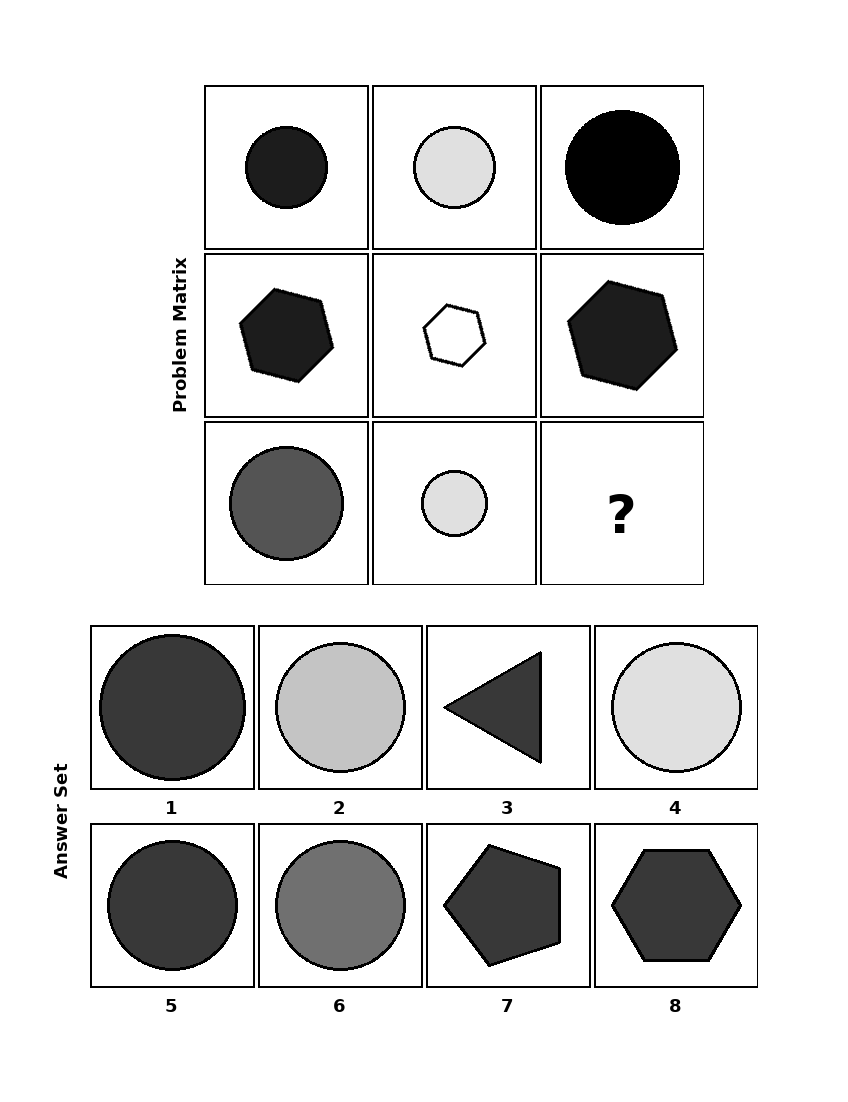
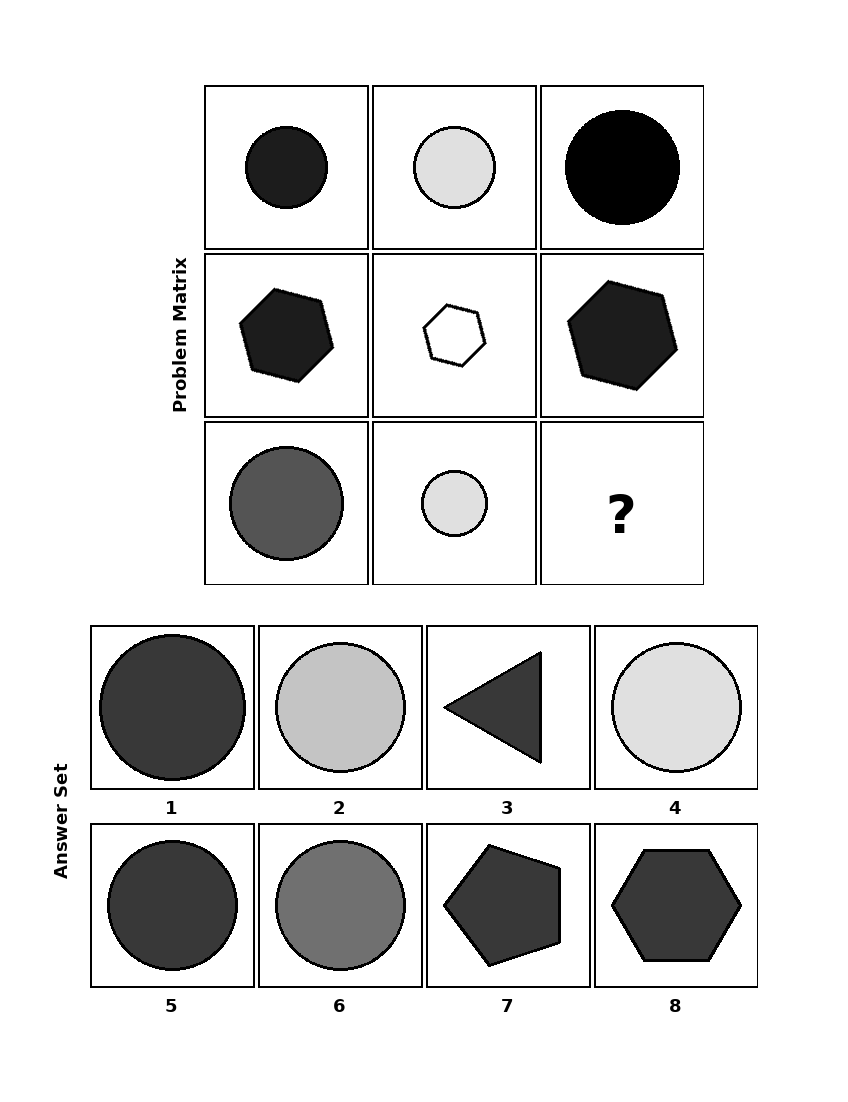
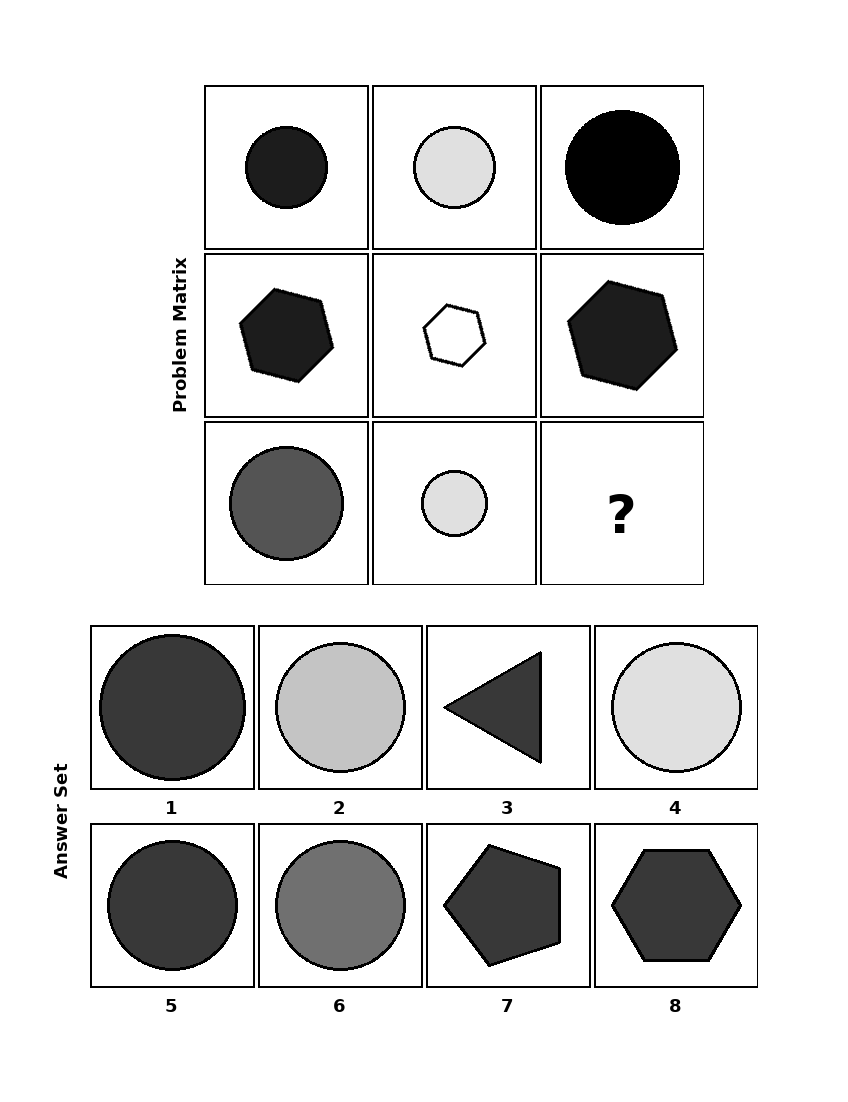
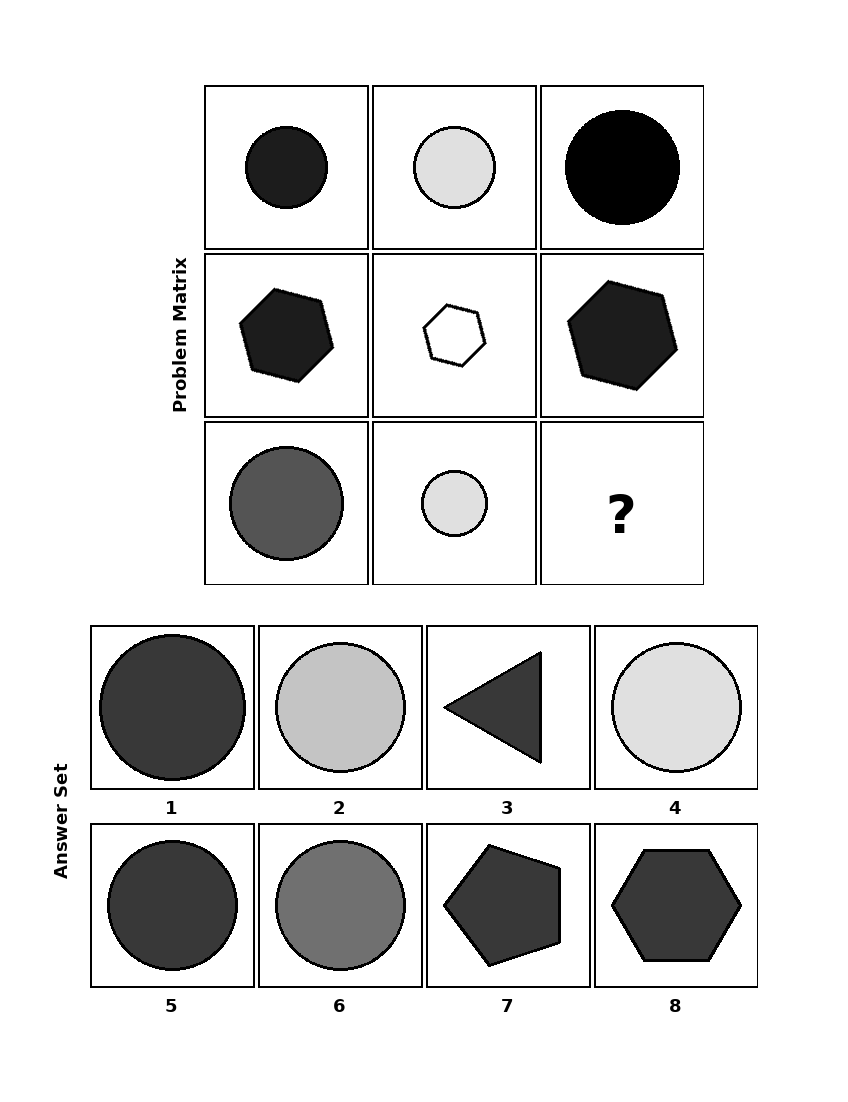
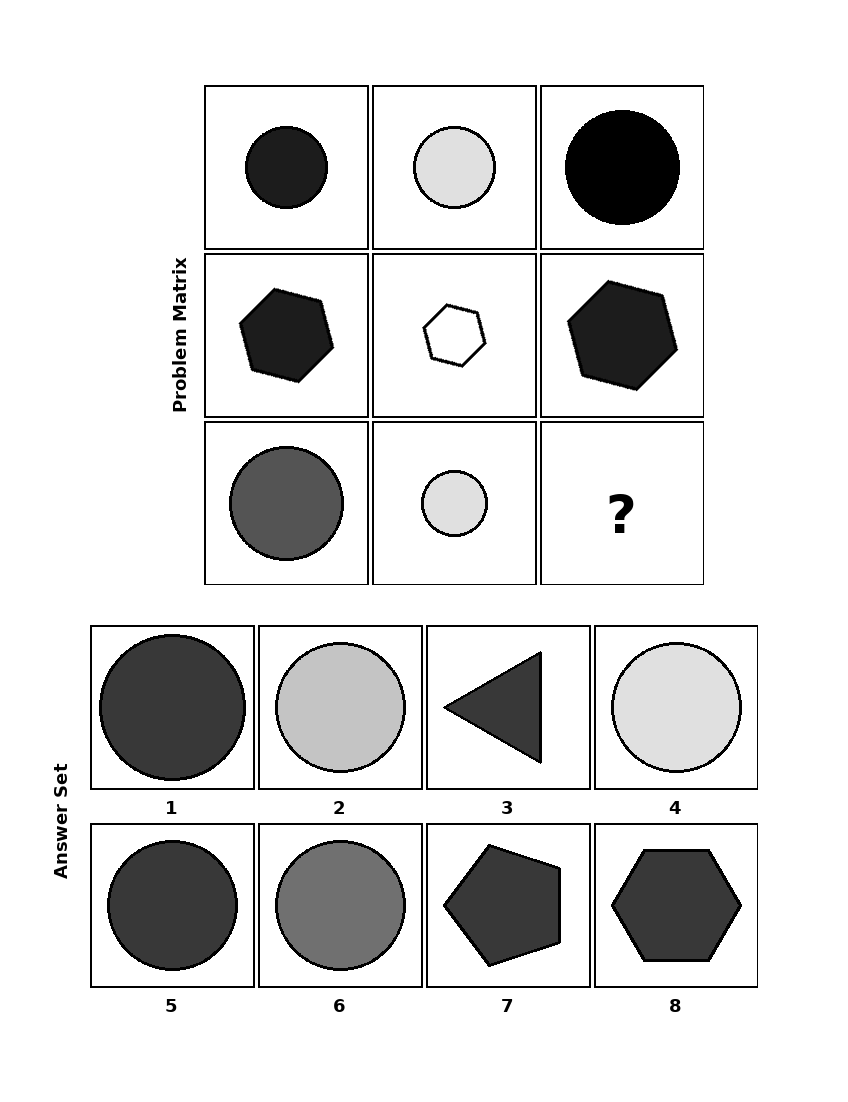
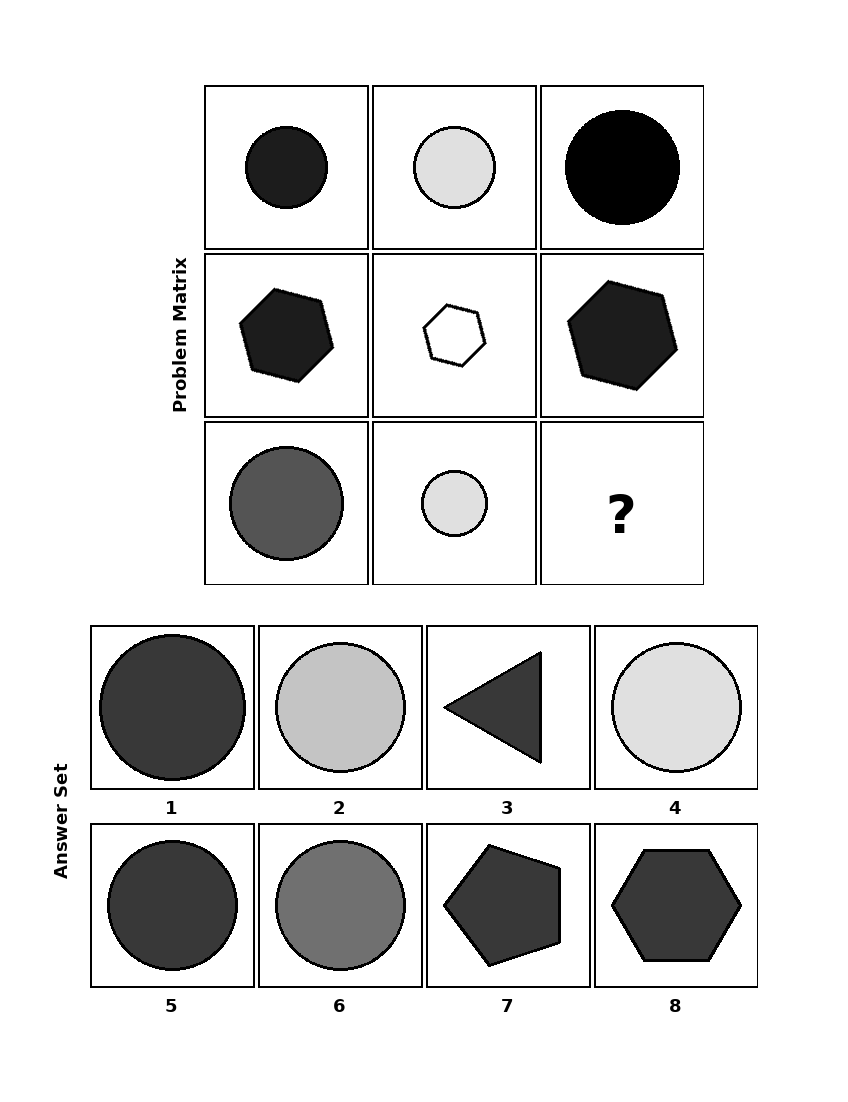
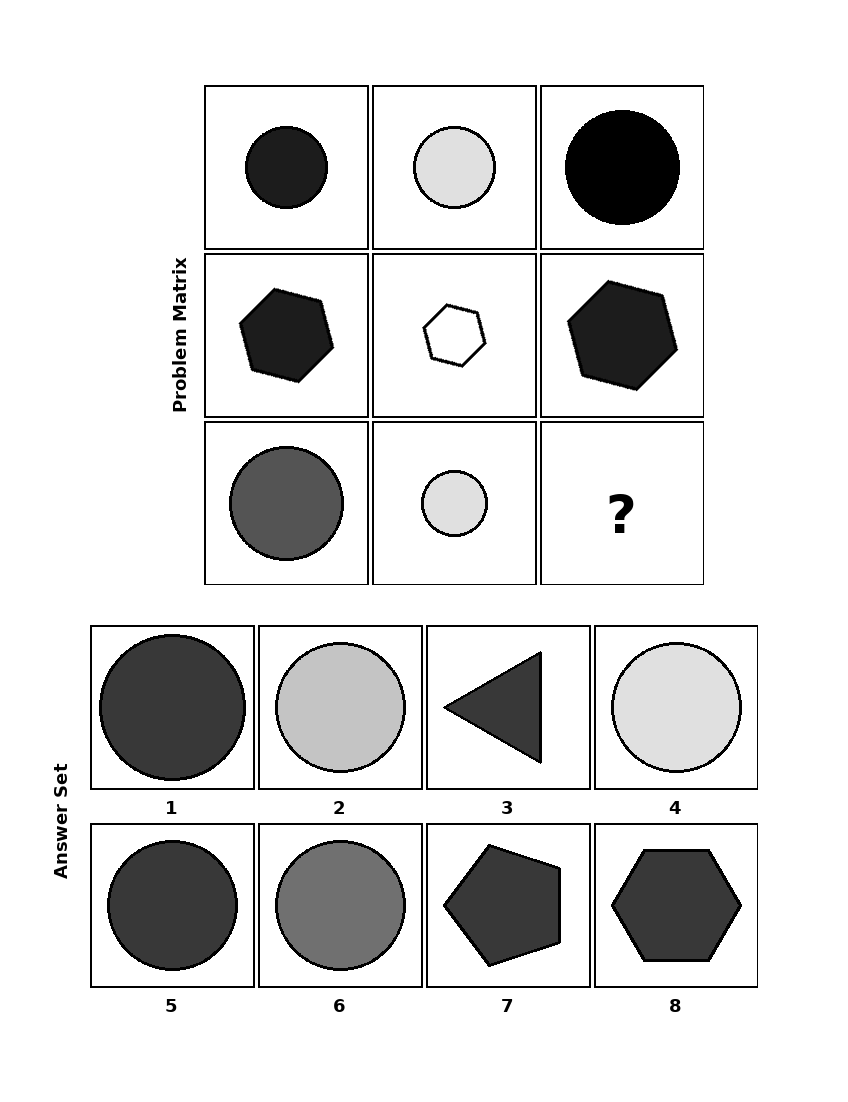
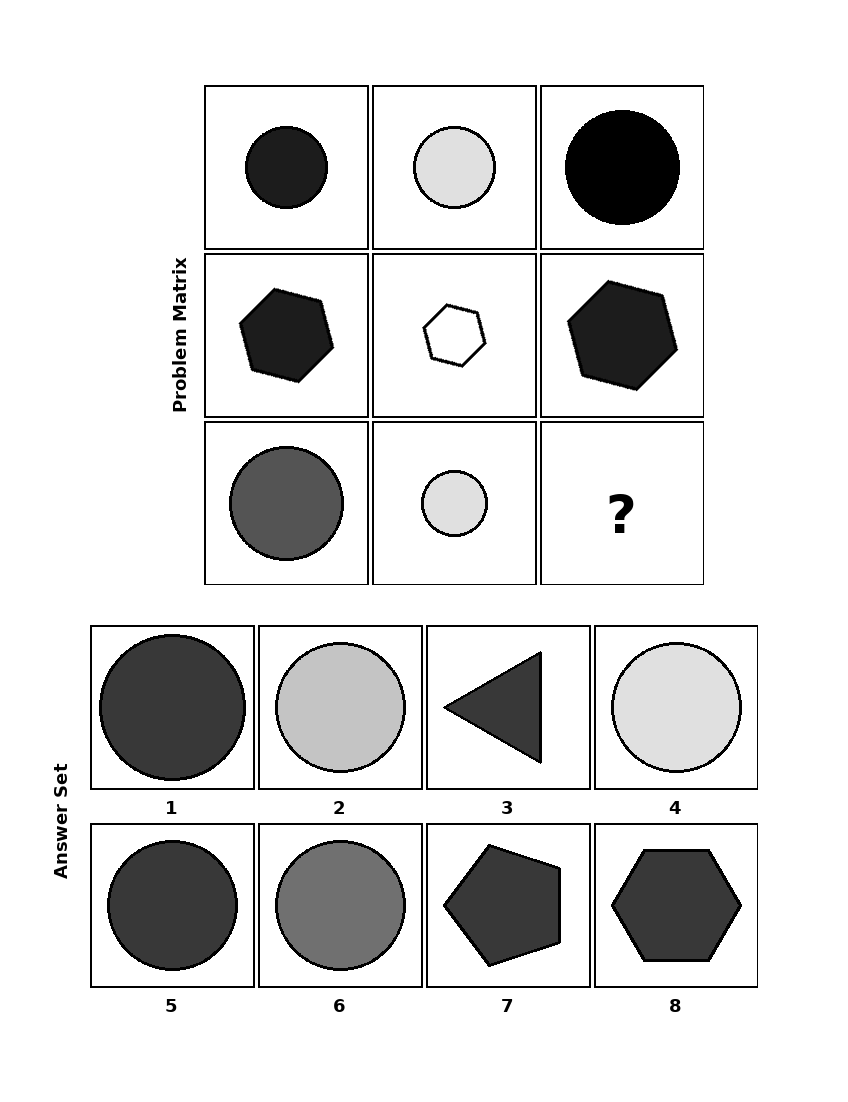
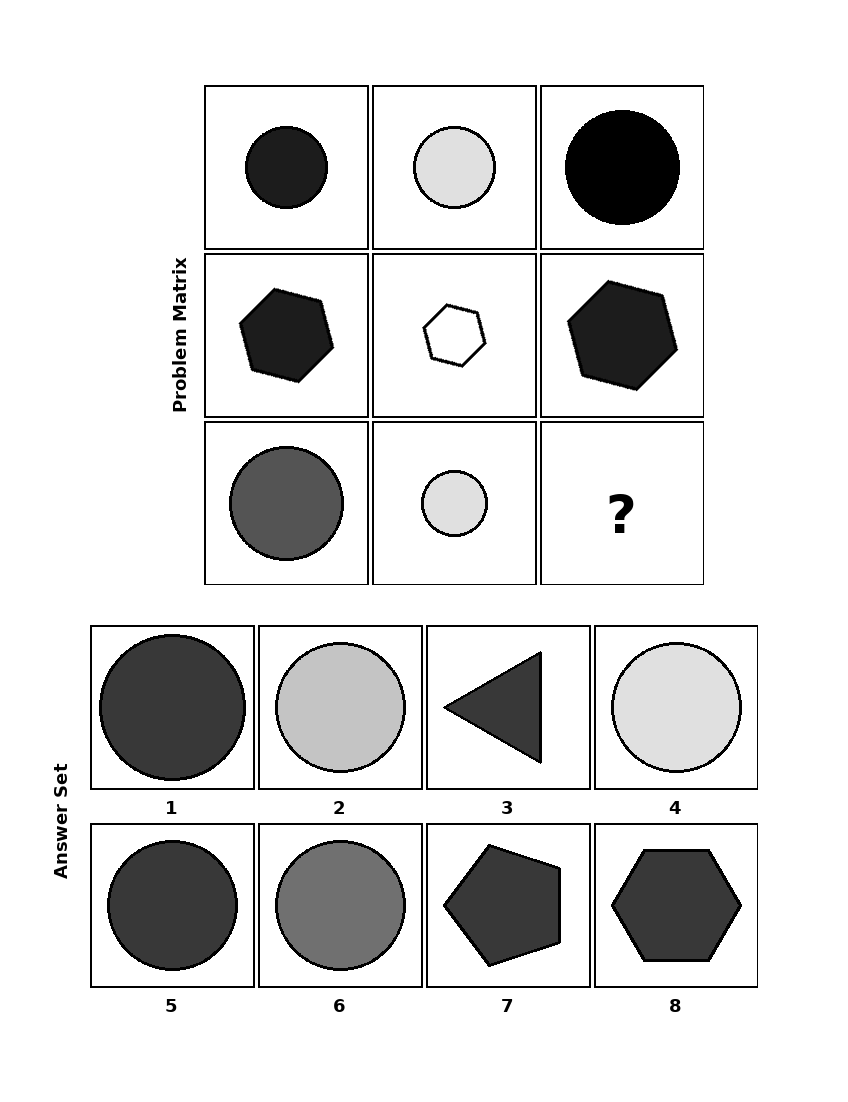
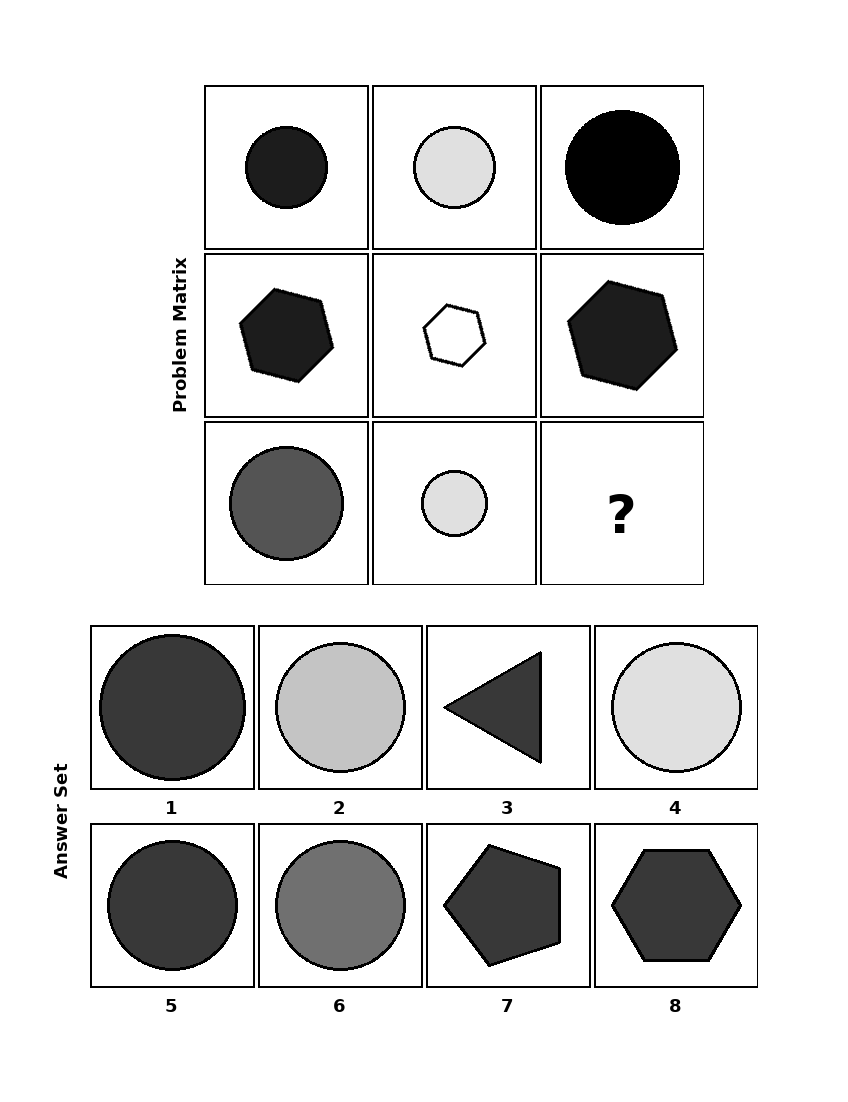
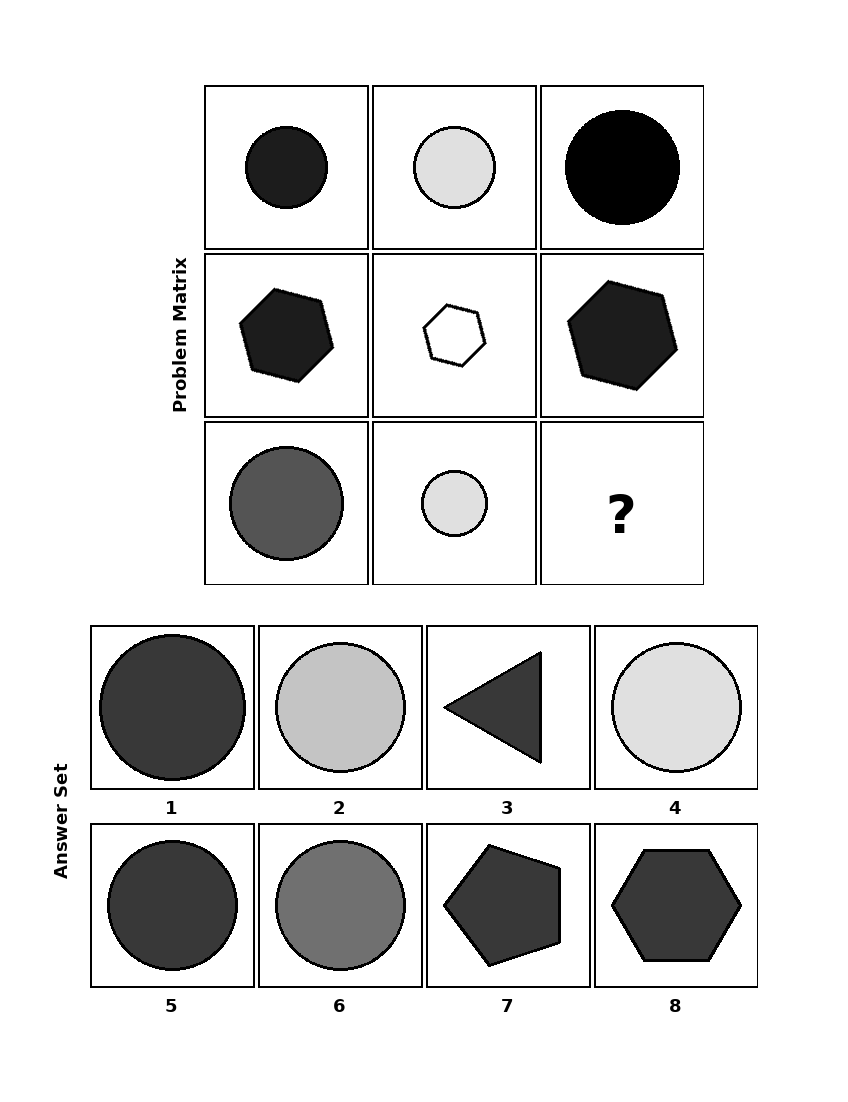
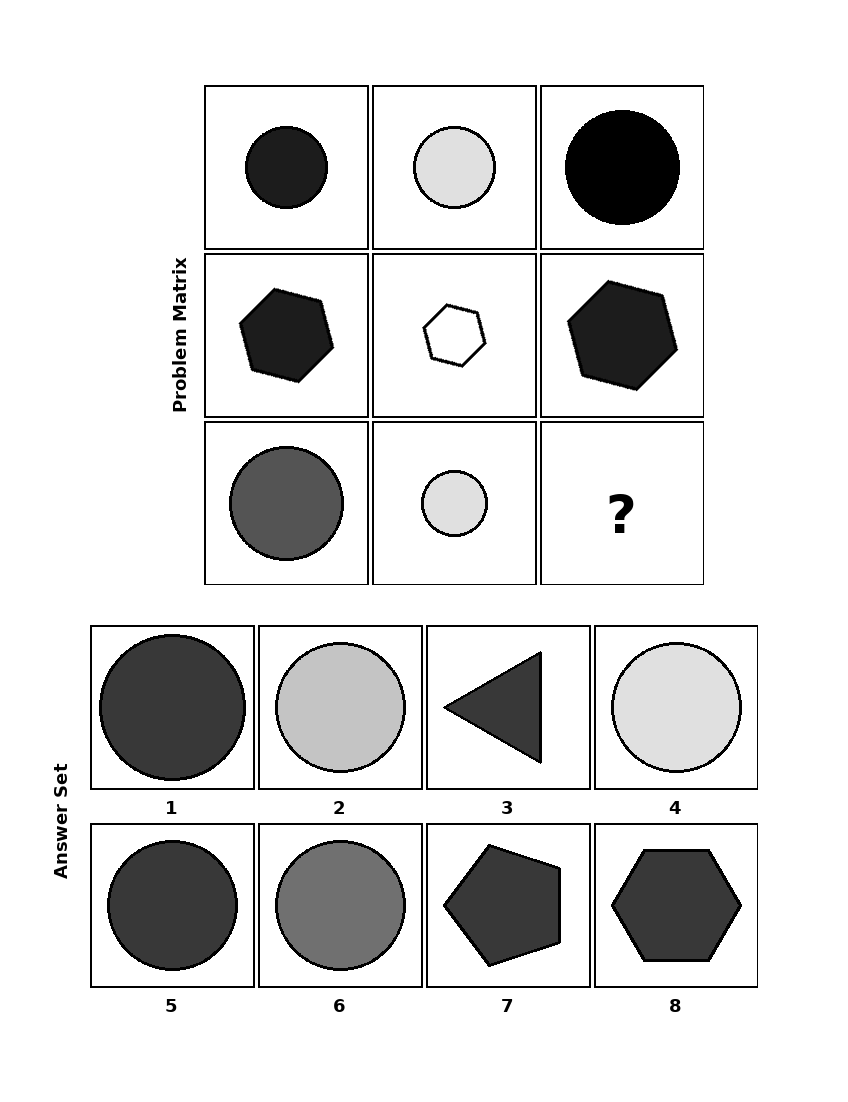
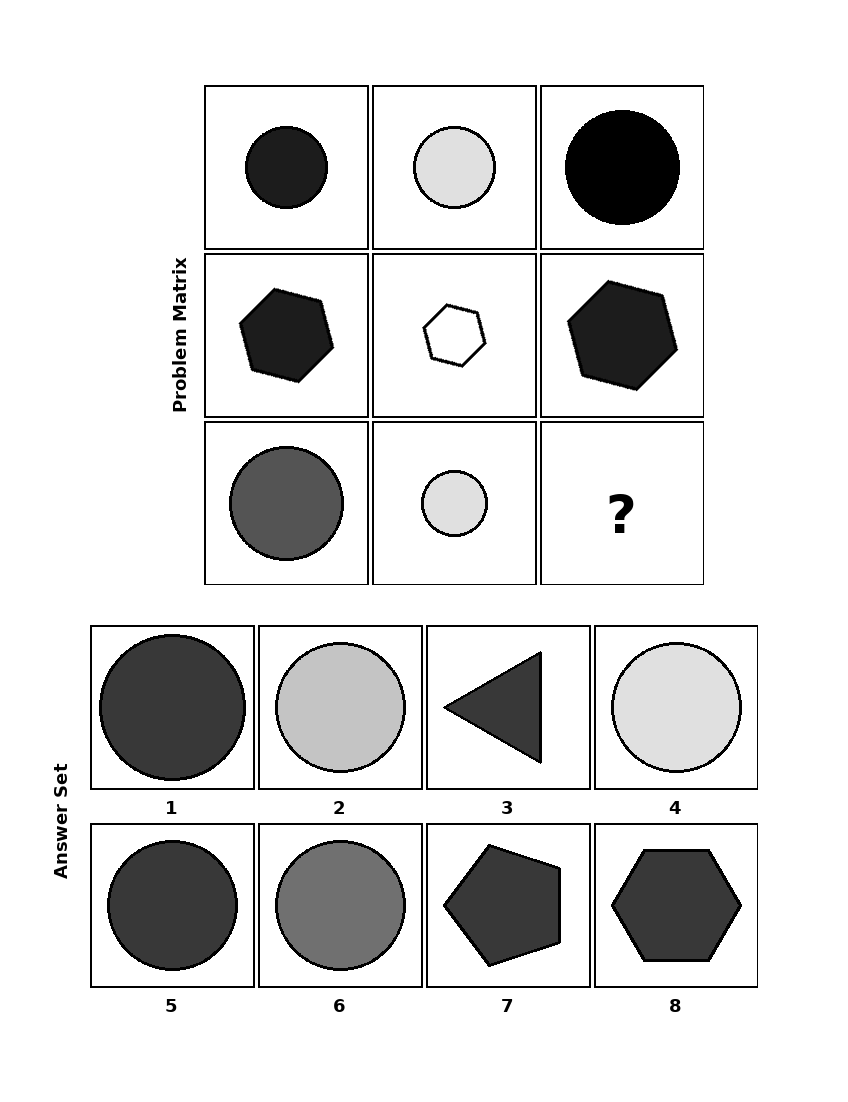
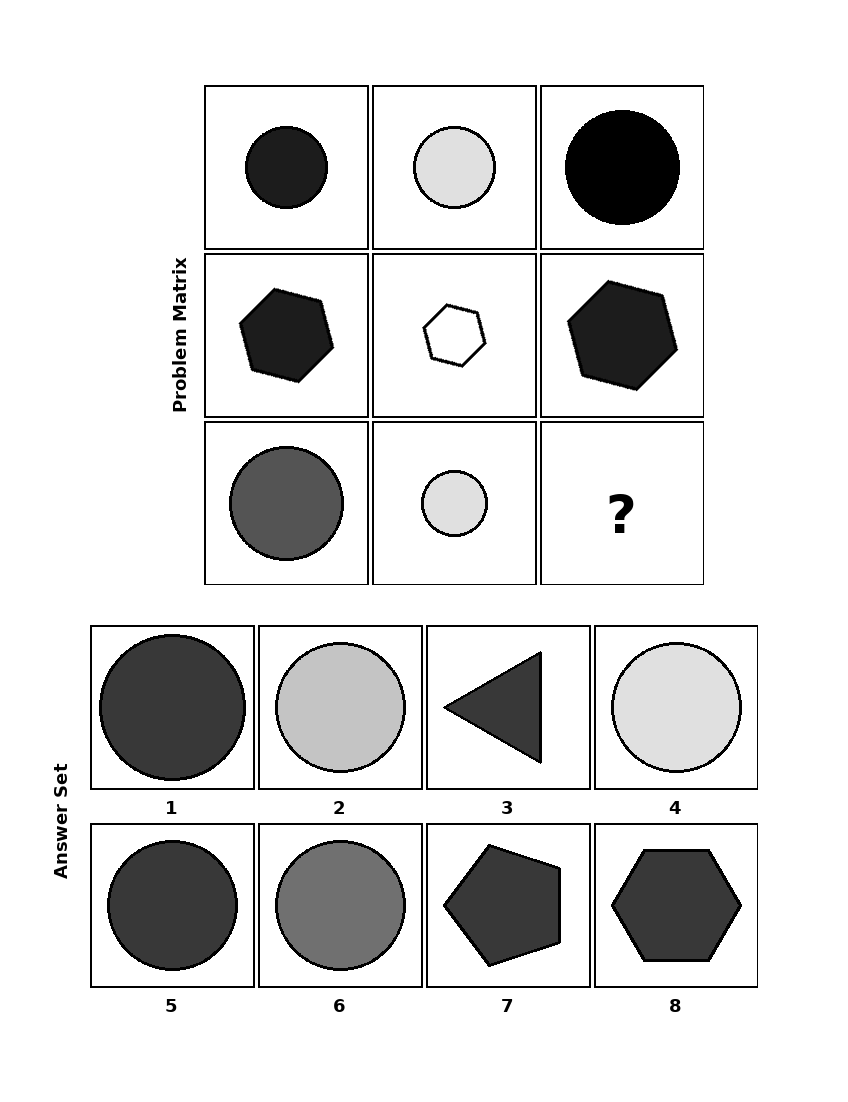
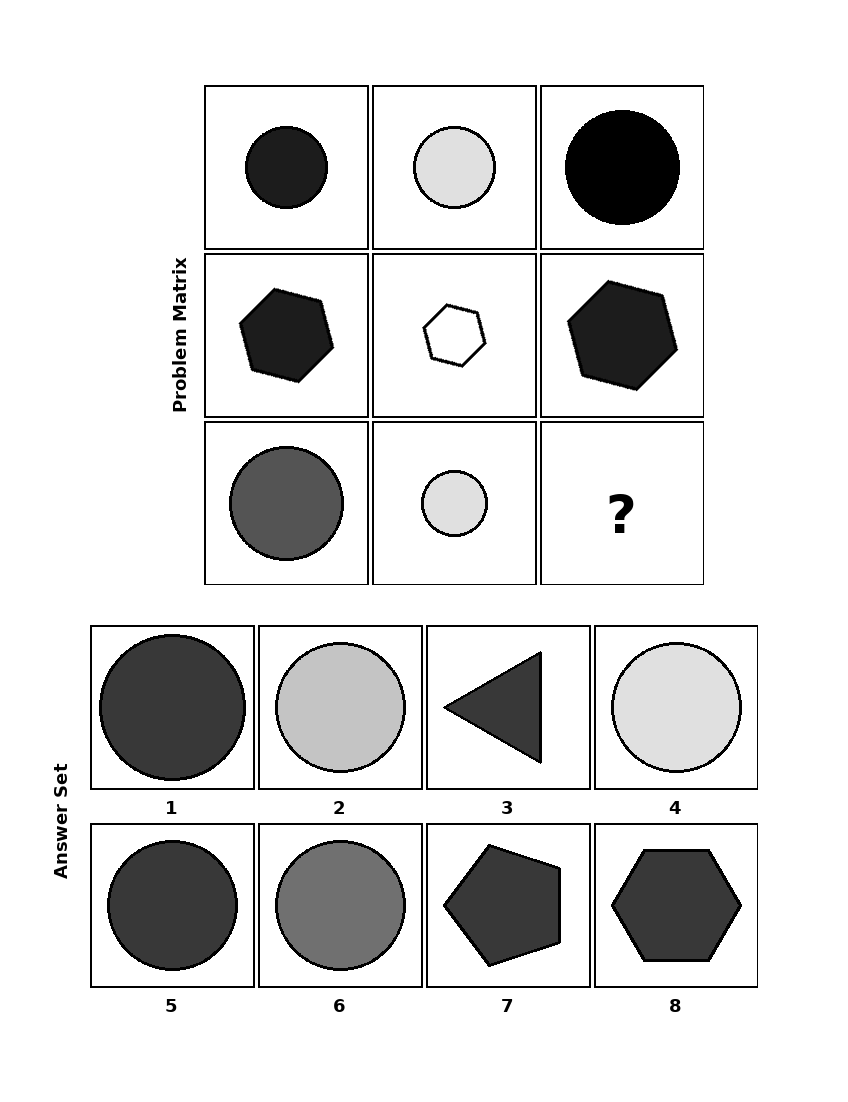
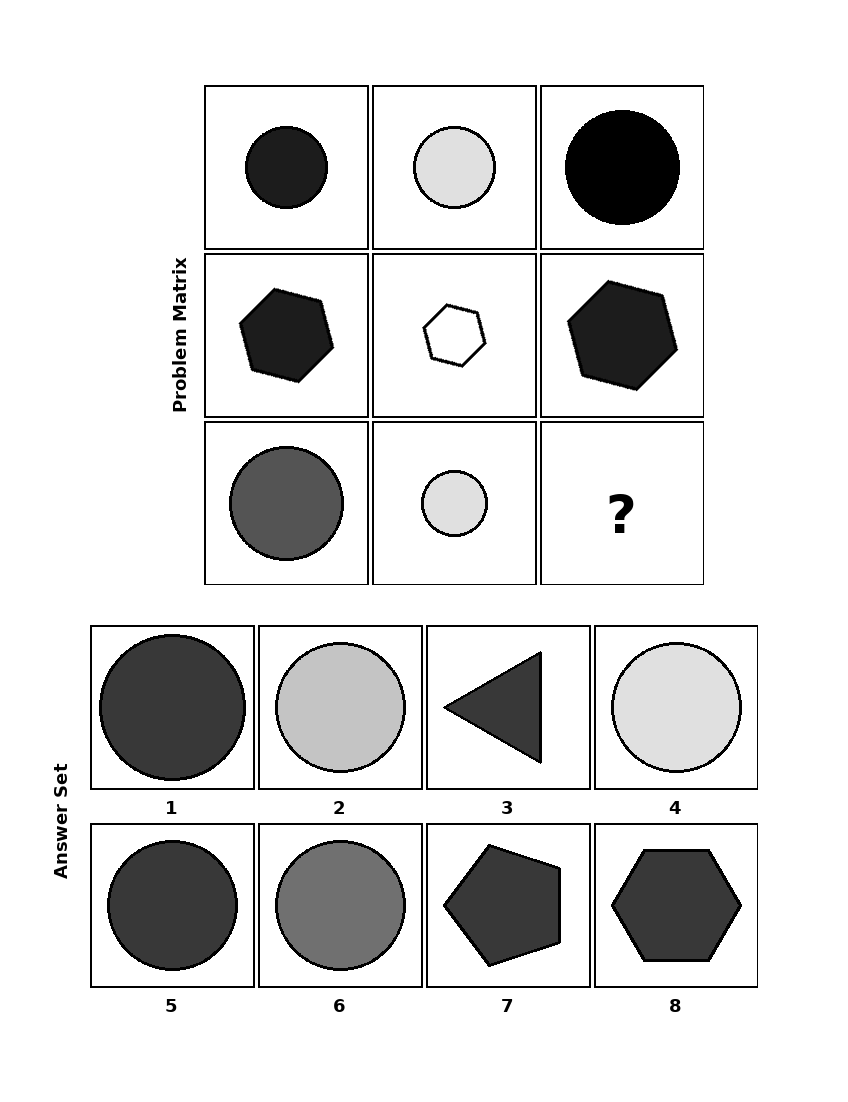
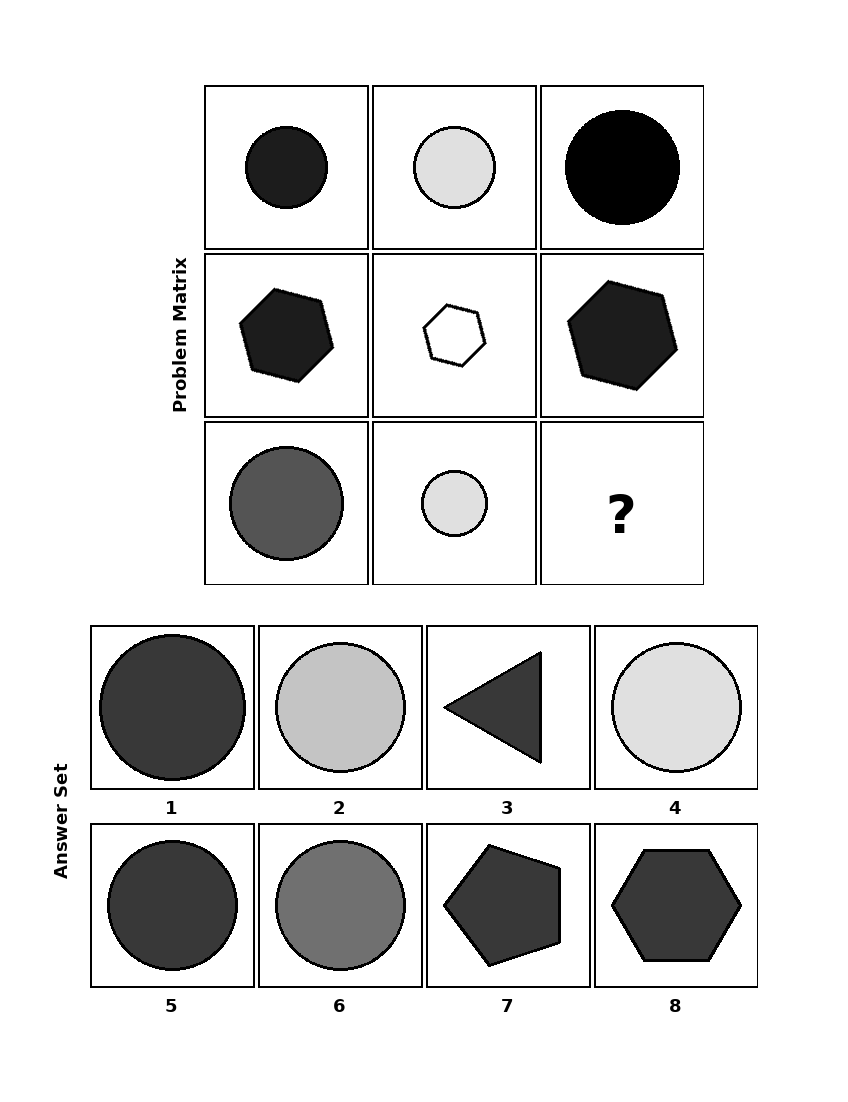
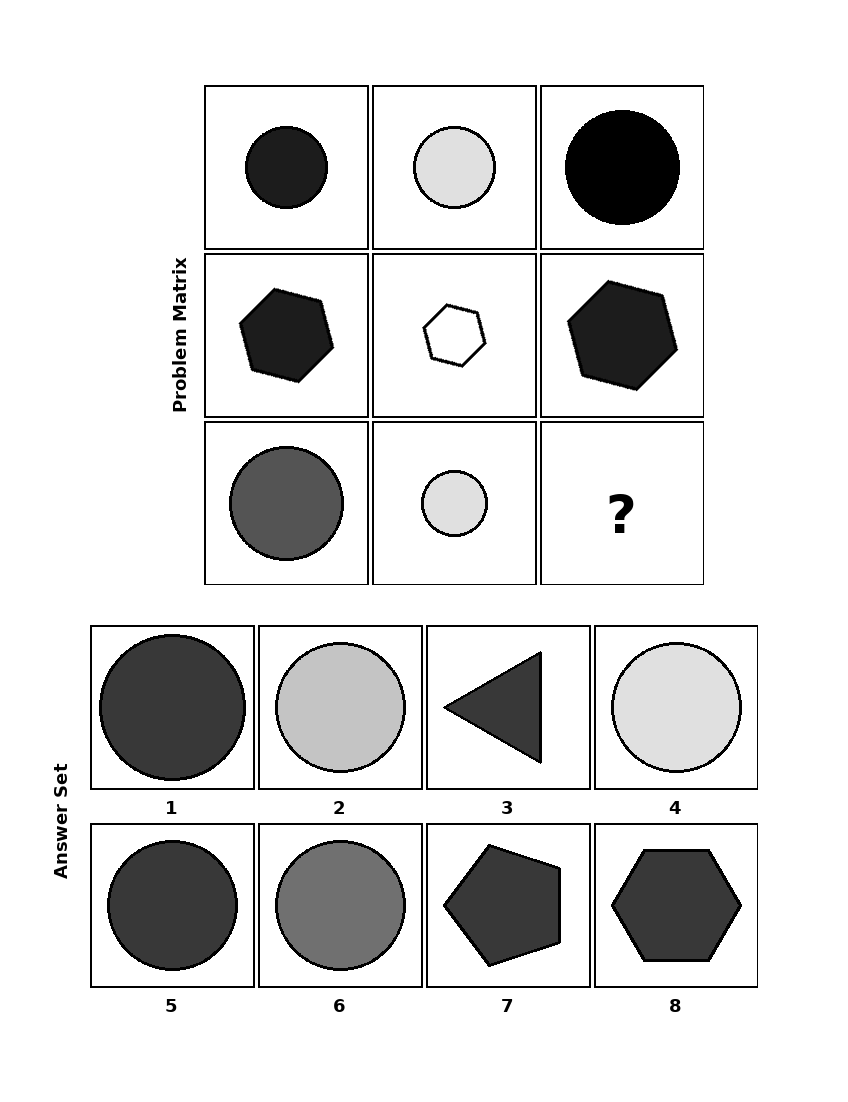

In [9]:
# Load and process RAVEN dataset
dataset = RAVENDataset(
    data=args['prompt_path'],
    sample_max_num=args['sample_max_num'],
    sample_start_idx=args['sample_start_idx'],
)

print(f"Dataset loaded: {len(dataset)} samples")

# Process a small batch for demonstration
batch_size = args['batch_size']
outputs = []

for i in range(0, min(len(dataset), batch_size)):
    sample = dataset[i]
    
    # Prepare input for processing
    inputs = [(sample['rollout_user_prompt'], sample['image'])]
    items = [sample['item']]
    
    print(f"\n[{localtime()}] Processing sample {i+1}/{min(len(dataset), batch_size)}")
    print(f"Image path: {sample['image_path']}")
    print(f"Correct answer: {sample['item']['correct_answer']}")
    
    # Generate process supervision data
    curr_outputs = build_process_supervision(
        inputs=inputs, # rollout_user_prompt, image
        items=items,
        num_return_sequences=args['num_return_sequences'],
        args=args
    )
    
#     outputs.extend(curr_outputs)
    
#     # Print first output for debugging
#     if i == 0:
#         print("\nFirst sample output:")
#         print_process_supervision(curr_outputs[0])

# print(f"\nGenerated {len(outputs)} rollout samples")


In [ ]:
# # Save outputs to file
# output_file = os.path.join(args['out_dir'], 'raven_step_by_step_rollouts.jsonl')

# with open(output_file, 'w') as f:
#     for output in outputs:
#         f.write(json.dumps(output) + '\n')

# print(f"Saved {len(outputs)} outputs to {output_file}")

# # Display summary statistics
# total_steps = sum(len(output['steps_with_score']) for output in outputs)
# avg_steps = total_steps / len(outputs) if outputs else 0
# avg_score = sum(
#     sum(step['score'] for step in output['steps_with_score']) / len(output['steps_with_score'])
#     for output in outputs if output['steps_with_score']
# ) / len(outputs) if outputs else 0

# print(f"\nSummary Statistics:")
# print(f"Total outputs: {len(outputs)}")
# print(f"Average steps per output: {avg_steps:.2f}")
# print(f"Average step score: {avg_score:.3f}")

# # Show sample output structure
# if outputs:
#     print(f"\nSample output keys: {list(outputs[0].keys())}")
#     if outputs[0]['steps_with_score']:
#         print(f"Sample step keys: {list(outputs[0]['steps_with_score'][0].keys())}")
